In [2]:
! pip install numpy
! pip install networkx
! pip install pgmpy|
! pip install ipdb
! pip install yfinance
! pip install matplotlib
! pip install arviz
! pip install pymc
! pip install bambi
! pip install pyreadline
! pip install pygraphviz
! pip install pydot

zsh:1: parse error near `|'
  Using cached requests-2.28.1-py3-none-any.whl (62 kB)
  Attempting uninstall: requests
    Found existing installation: requests 2.21.0
    Uninstalling requests-2.21.0:
      Successfully uninstalled requests-2.21.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchdata 0.4.1 requires urllib3>=1.25, but you have urllib3 1.24.3 which is incompatible.
tensorboard 2.9.1 requires google-auth<3,>=1.6.3, but you have google-auth 1.4.2 which is incompatible.


  Using cached pandas-1.3.5-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.3 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 0.24.2
    Uninstalling pandas-0.24.2:
      Successfully uninstalled pandas-0.24.2
  Using cached bambi-0.9.1-py3-none-any.whl (50 kB)
  Using cached formulae-0.3.4-py3-none-any.whl (44 kB)


  Using cached pyreadline-2.1.zip (109 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for pyreadline: filename=pyreadline-2.1-py3-none-any.whl size=93834 sha256=1b3c7c749dee8986959a0f3b210247a673e539e39e4edbfb0f671b075d59a6c2
  Stored in directory: /home/fanpu/.cache/pip/wheels/2c/ba/0a/79cfdda2594b992540020a641a4abc70764064f532acbe56b4
Successfully built pyreadline
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.8/118.8 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pygraphviz: filename=pygraphviz-1.7-cp37-cp37m-linux_x86_64.whl size=174236 sha256=fcb984980ff83cd05c0b96dbd6d4899249839f3a1547c73690c0d0516b7ebf25
  Stored in directory: /home/fanpu/.cache/pip/wheels/bd/f8/1e/70c8130ebd7df10c3488384285ba59532571251ac8ac5c922a
Successfully built pygraphviz
  Using cached pydot-1.4.2-py2.py3-none-any.whl (21 kB)


In [1]:
import networkx
import pickle
import numpy as np
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pickle
import matplotlib.pyplot as plt
from pprint import pprint
import bambi as bmb
import xarray as xr
from StockEngine import StockEngine
from tqdm import tqdm
import ipdb

%config IPCompleter.greedy=True


In [44]:
def predictions_vol_file(tday):
    return f"predictions/{tday}_vol.pkl"

def predictions_corr_file(tday):
    return f"predictions/{tday}_corr.pkl"

with open("adj_mat.pkl", "rb") as f:
    G = pickle.load(f)
    
G.remove_node('DVA')
G.remove_node('ULTA')

tickers = list(G.nodes())

# UNCOMMENT IN FUTURE
# tickers = tickers[:5]

ticker_to_index = {}
for i, ticker in enumerate(tickers):
    ticker_to_index[ticker] = i
print(tickers)
print(ticker_to_index)
num_tickers = len(tickers)
corr_len = num_tickers * (num_tickers - 1) // 2

start_date = "2010-01-01"
end_date = "2022-12-06"

prediction_folder="predictions"

engine = StockEngine(tickers, start_date=start_date, end_date=end_date)

['CTSH', 'CI', 'CMS', 'ROST', 'JNJ', 'PFG', 'PAYX', 'AON', 'FIS', 'DXC', 'ROK', 'AMZN', 'ISRG', 'PNR', 'GWW', 'LNT', 'CE', 'NKE', 'MCO', 'AEP', 'TPR', 'UNH', 'NVR', 'XEL', 'TTWO', 'CMG', 'GIS', 'WST', 'CAT', 'XRAY', 'ANSS', 'QCOM', 'INTC', 'LIN', 'MU', 'GPC', 'ITW', 'EL', 'DXCM', 'COO', 'PKG', 'AMD', 'ETN', 'MHK', 'IEX', 'HON', 'MKC', 'MO', 'BIO', 'DIS', 'NFLX', 'RL', 'CSX', 'T', 'WM', 'TER', 'CRL', 'CL', 'JKHY', 'USB', 'COF', 'TFC', 'GS', 'AVB', 'UDR', 'ESS', 'HIG', 'PEAK', 'SYY', 'WAT', 'BWA', 'NEE', 'PPL', 'LLY', 'INCY', 'LVS', 'COST', 'XOM', 'SLB', 'DVN', 'WMB', 'PXD', 'EOG', 'PSA', 'TSCO', 'TAP']
{'CTSH': 0, 'CI': 1, 'CMS': 2, 'ROST': 3, 'JNJ': 4, 'PFG': 5, 'PAYX': 6, 'AON': 7, 'FIS': 8, 'DXC': 9, 'ROK': 10, 'AMZN': 11, 'ISRG': 12, 'PNR': 13, 'GWW': 14, 'LNT': 15, 'CE': 16, 'NKE': 17, 'MCO': 18, 'AEP': 19, 'TPR': 20, 'UNH': 21, 'NVR': 22, 'XEL': 23, 'TTWO': 24, 'CMG': 25, 'GIS': 26, 'WST': 27, 'CAT': 28, 'XRAY': 29, 'ANSS': 30, 'QCOM': 31, 'INTC': 32, 'LIN': 33, 'MU': 34, 'GPC': 3

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:00<00:00, 559.96it/s]


In [45]:

from networkx.drawing.nx_pydot import write_dot
pos = networkx.nx_agraph.graphviz_layout(G)
nx.draw(G, with_labels=True, pos=pos)
write_dot(G, 'file.dot')

NameError: name 'nx' is not defined

In [52]:
import datetime

num_prev_trading_days = 126
months_to_evaluate = 11 # * 10
evaluation_year_month_start = "2012-01"

In [53]:
def convert_to_lower_triangular(A, dimension):
    C = np.zeros((A.shape[0], dimension, dimension))
    B = np.zeros((dimension, dimension))
    idx = np.tril_indices_from(B, -1)
    
    for i in range(len(A)):
        C[i][idx] = A[i]
    return C

In [54]:
def reconstruct_coefficients_vol(vol, ticker):
    return (
        vol[ticker].posterior['alpha'][0][-1].to_numpy(),
        vol[ticker].posterior['betas_day'][0][-1].to_numpy(),
        vol[ticker].posterior['betas_week'][0][-1].to_numpy(),
        vol[ticker].posterior['betas_month'][0][-1].to_numpy(),
    )

def reconstruct_coefficients_corr(corr):
    return (
        corr.posterior['alpha'][0][-1].to_numpy(),
        corr.posterior['betas_day'][0][-1].to_numpy(),
        corr.posterior['betas_week'][0][-1].to_numpy(),
        corr.posterior['betas_month'][0][-1].to_numpy(),
    )

In [55]:
def make_prediction(tday, vol, corr):
    _, RVt1, RVt25, RVt626, _, xt1, xt25, xt626 = engine.get_HAR_DRD_data(tday)
    
    # Reconstruct RV_t
    predicted_RV_t = np.zeros(num_tickers)
    for ticker_index in range(num_tickers):
        ticker = tickers[ticker_index]
        
        neighbors = list(G.adj[ticker].keys())
        alpha, betas_day, betas_week, betas_month = vol[ticker]
        
        predicted_RV_t[ticker_index] += alpha
        predicted_RV_t[ticker_index] += betas_day[0] * RVt1[ticker_index]
        predicted_RV_t[ticker_index] += betas_week[0] * RVt25[ticker_index]
        predicted_RV_t[ticker_index] += betas_month[0] * RVt626[ticker_index]
        
        for i, neighbor_ticker in enumerate(neighbors):
            neighbor_ticker_index = ticker_to_index[neighbor_ticker]
            predicted_RV_t[ticker_index] += betas_day[i+1] * RVt1[neighbor_ticker_index] 
            predicted_RV_t[ticker_index] += betas_week[i+1] * RVt25[neighbor_ticker_index] 
            predicted_RV_t[ticker_index] += betas_month[i+1] * RVt626[neighbor_ticker_index] 
    
    
    # Reconstruct R_t
    alpha, betas_day, betas_week, betas_month = corr
    predicted_R_t = alpha + betas_day * xt1 + betas_week * xt25 + betas_month * xt626
    predicted_R_t = np.clip(predicted_R_t, -1, 1)

#     D_t = np.diag(np.sqrt(predicted_RV_t))
    D_t = np.diag(np.sqrt(np.maximum(predicted_RV_t, 0)))
    R_t = np.zeros((num_tickers, num_tickers))
    R_t[np.tril_indices_from(R_t, -1)] = predicted_R_t
    R_t += R_t.T
    
    H_t = D_t @ R_t @ D_t
    
    return H_t
    
# Old code under the assumption we had unique coeff for each :3
#     predicted_R_t = np.zeros(corr_len)
#     indices = np.tril_indices_from(np.zeros((num_tickers, num_tickers)))
#     indices_list = list(zip(new_idx[0], new_idx[1]))
#     for idx, (ticker_1_index, ticker_2_index) in enumerate(indices_list):
#         alpha, betas_day, betas_week, betas_month = reconstruct_coefficients(vol, ticker)
        
#         predicted_R_t[idx] += 
        
    

In [56]:
def loss_frobenius(cov1, cov2):
    return np.linalg.norm(cov1 - cov2, ord='fro')

2012-01-03 Loss 0.21433154999865506


 68%|████████████████████████████████████████████████████████████████████████▎                                 | 249/365 [00:36<00:17,  6.77it/s]


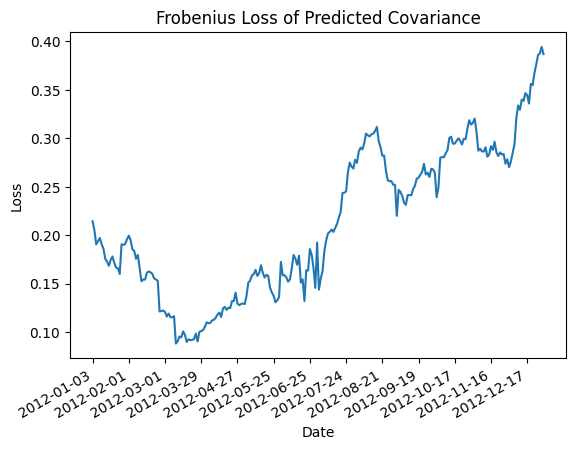

2013-01-02 Loss 0.12658043017685877


 69%|████████████████████████████████████████████████████████████████████████▉                                 | 251/365 [00:35<00:16,  7.02it/s]


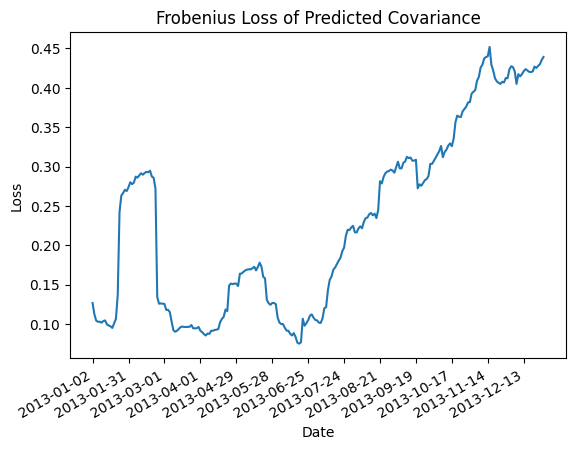

2014-01-02 Loss 0.0699930745460432


 69%|████████████████████████████████████████████████████████████████████████▉                                 | 251/365 [00:39<00:17,  6.42it/s]


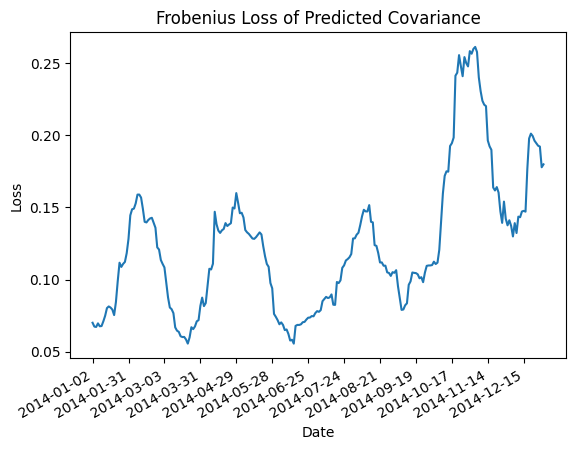

2015-01-02 Loss 0.09316150235751114


 69%|████████████████████████████████████████████████████████████████████████▉                                 | 251/365 [00:38<00:17,  6.56it/s]


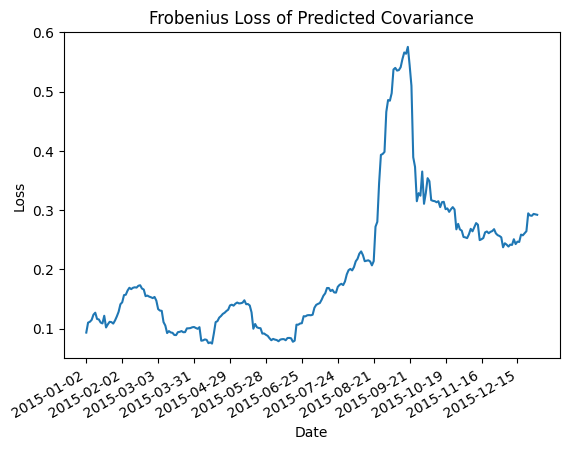

2016-01-04 Loss 0.22988100636489125


 69%|████████████████████████████████████████████████████████████████████████▉                                 | 251/365 [00:39<00:17,  6.37it/s]


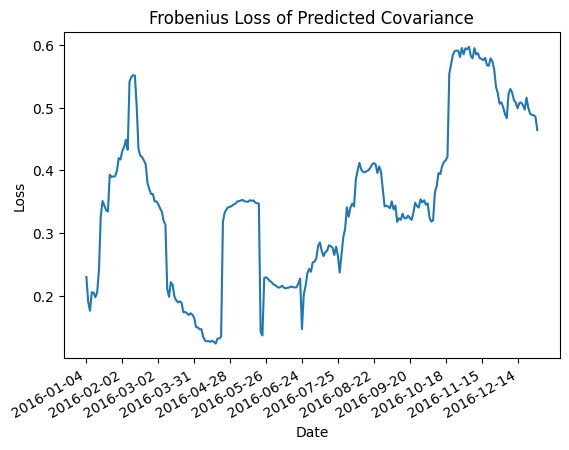

2017-01-03 Loss 0.2199399081311001


 68%|████████████████████████████████████████████████████████████████████████▌                                 | 250/365 [00:30<00:14,  8.08it/s]


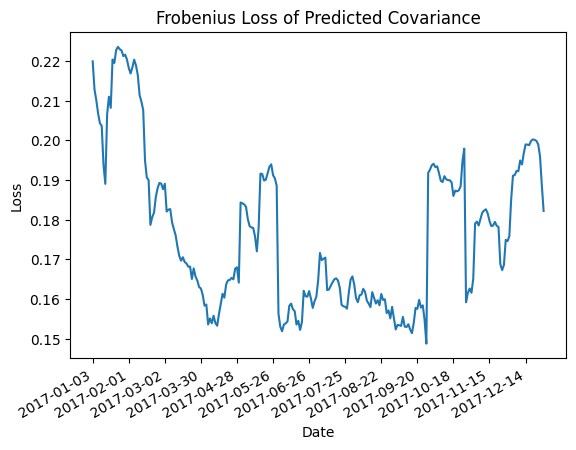

2018-01-02 Loss 0.2950584506569262


 68%|████████████████████████████████████████████████████████████████████████▌                                 | 250/365 [00:31<00:14,  7.89it/s]


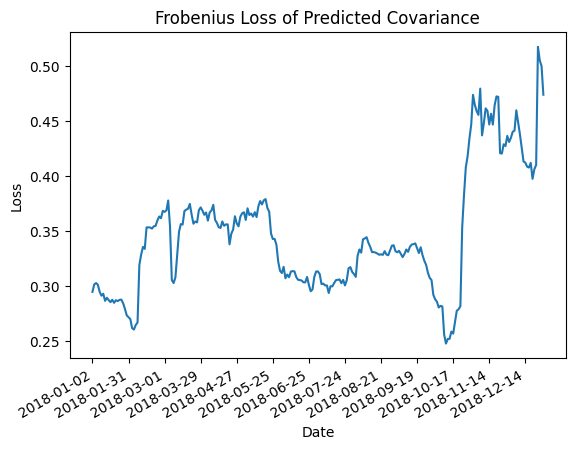

2019-01-02 Loss 0.47846978298219656


 69%|████████████████████████████████████████████████████████████████████████▉                                 | 251/365 [00:33<00:15,  7.56it/s]


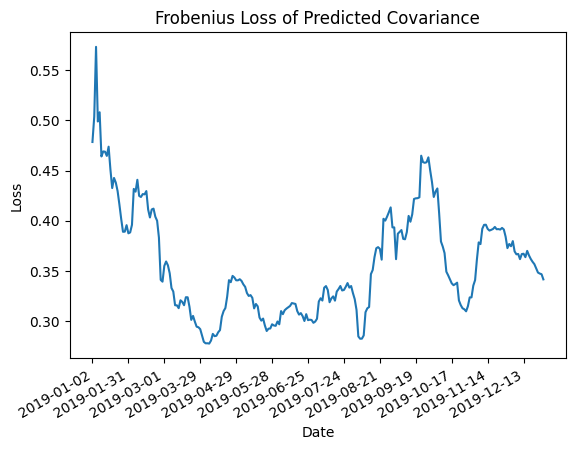

2020-01-02 Loss 0.42627626484004116


 69%|█████████████████████████████████████████████████████████████████████████▏                                | 252/365 [00:33<00:14,  7.59it/s]


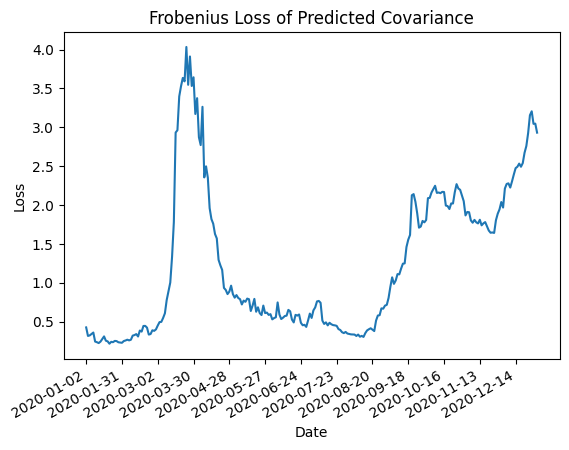

2021-01-04 Loss 0.14041254422892369


 69%|████████████████████████████████████████████████████████████████████████▉                                 | 251/365 [00:29<00:13,  8.50it/s]


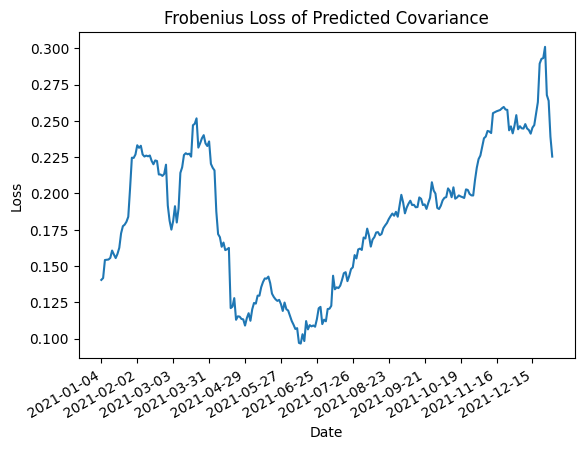

2022-01-03 Loss 0.1450747354342521


 63%|██████████████████████████████████████████████████████████████████▌                                       | 229/365 [00:26<00:15,  8.64it/s]


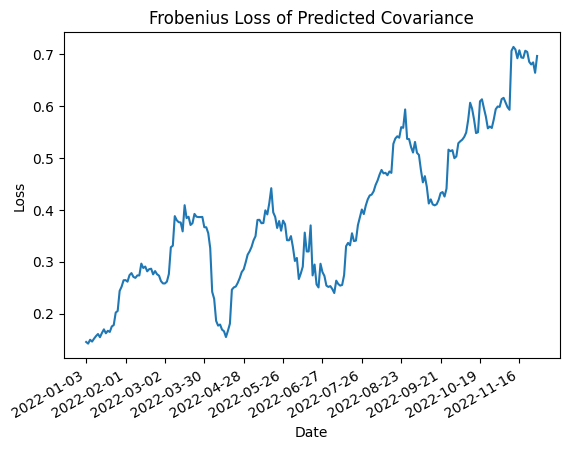

In [57]:
import pandas as pd
import matplotlib.dates as mdates
import csv

USE_YEARLY = True

def dump_list_as_csv(data, filepath):
    with open(filepath, 'w') as csvfile:
        writer = csv.writer(csvfile)
        for row in data:
            writer.writerow(row)

def make_yearly_prediction_starting_from(tday, vol, corr):
    start_year = tday[:4]
    timestamps = []
    losses = []
    
    for _ in tqdm(range(365)):
        predicted_H_t = make_prediction(tday, vol, corr)
        H_t, _, _, _ = engine.get_HAR_DRD(tday)
        loss = loss_frobenius(predicted_H_t, H_t)
        timestamps.append(tday)
        losses.append(loss)
        
        tday = engine.get_shift_tday(tday, 1)
        if tday[:4] != start_year:
            break
        if tday == "2022-12-01":
            break
#     dates = pd.to_datetime(timestamps)

    dump_list_as_csv(zip(timestamps, losses), f"predictions/{start_year}_loss.csv")

    plt.plot(timestamps, losses)
    plt.xlabel("Date")
    plt.ylabel("Loss")
    plt.gcf().autofmt_xdate()
    plt.xticks(timestamps[0::20])
    plt.title("Frobenius Loss of Predicted Covariance")
    plt.savefig("prediction_figs/loss-" + start_year + ".png")
    plt.show()
    
    with open(f"predictions/{start_year}_loss.pkl", "wb") as f:
        pickle.dump({"timestamps" : timestamps, "losses" : losses}, f)
    
    return (timestamps, losses)

all_timestamps = []
all_losses = []
all_predicted_H_t = {}

for month_diff in range(months_to_evaluate):
    if USE_YEARLY:
        year_month = engine.get_shift_month(evaluation_year_month_start, month_diff * 12)
    else:
        year_month = engine.get_shift_month(evaluation_year_month_start, month_diff) 
        
    start_day = 1
    tday = year_month + "-{:02d}".format(start_day)
    if tday[:4] == "2023":
        break
    while tday not in engine.trading_day_list:
        start_day += 1
        tday = year_month + "-{:02d}".format(start_day) 

    with open(predictions_vol_file(tday), "rb") as f:
        vol = pickle.load(f)
    with open(predictions_corr_file(tday), "rb") as f:
        corr = pickle.load(f)
        
    predicted_H_t = make_prediction(tday, vol, corr)
    all_predicted_H_t[tday] = predicted_H_t
    H_t, _, _, _ = engine.get_HAR_DRD(tday)
    loss = loss_frobenius(predicted_H_t, H_t)
    print(f"{tday} Loss", loss)
    
    timestamps, losses = make_yearly_prediction_starting_from(tday, vol, corr)
    all_timestamps += timestamps
    all_losses += losses
    
#     with open(f"evaluation/{tday}_evaluation.pkl", "wb") as f:
#         pickle.dump({"predicted_H_t" : predicted_H_t,
#                 "H_t" : H_t,
#                 "loss": loss
#                }, f)
#     losses.append(loss)

In [60]:
with open(f"predictions/all_predicted_H_t.pkl", "wb") as f:
    pickle.dump(all_predicted_H_t, f)
    
dump_list_as_csv(zip(all_timestamps, all_losses), f"predictions/all_loss.csv")

In [61]:
all_predicted_H_t

{'2012-01-03': array([[0.        , 0.00355599, 0.00223063, ..., 0.00191535, 0.0017109 ,
         0.00132799],
        [0.00355599, 0.        , 0.00546613, ..., 0.00238293, 0.00358006,
         0.0029492 ],
        [0.00223063, 0.00546613, 0.        , ..., 0.00130636, 0.0018043 ,
         0.00217576],
        ...,
        [0.00191535, 0.00238293, 0.00130636, ..., 0.        , 0.00121241,
         0.00089302],
        [0.0017109 , 0.00358006, 0.0018043 , ..., 0.00121241, 0.        ,
         0.00124839],
        [0.00132799, 0.0029492 , 0.00217576, ..., 0.00089302, 0.00124839,
         0.        ]]),
 '2013-01-02': array([[0.        , 0.00166922, 0.00067526, ..., 0.00110521, 0.00080697,
         0.00047937],
        [0.00166922, 0.        , 0.00356397, ..., 0.00194257, 0.00316395,
         0.00270294],
        [0.00067526, 0.00356397, 0.        , ..., 0.00088392, 0.0012093 ,
         0.00094766],
        ...,
        [0.00110521, 0.00194257, 0.00088392, ..., 0.        , 0.00102668,
      

In [62]:
# Create plot comparing baseline & UGM
def load_csv(file_name):
    data = []
    with open(file_name, "r") as csv_file:
        reader = csv.reader(csv_file)
        for row in reader:
            data.append(row)
    return data

baseline_loss = load_csv("HAR_DRD_eval.csv")
ugm_loss = load_csv("predictions/all_loss.csv")

/tmp/ipykernel_1762534/2610087864.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  baseline_vals = losses[:, 0, 1].astype(np.float)
/tmp/ipykernel_1762534/2610087864.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ugm_vals = losses[:, 1, 1].astype(np.float)


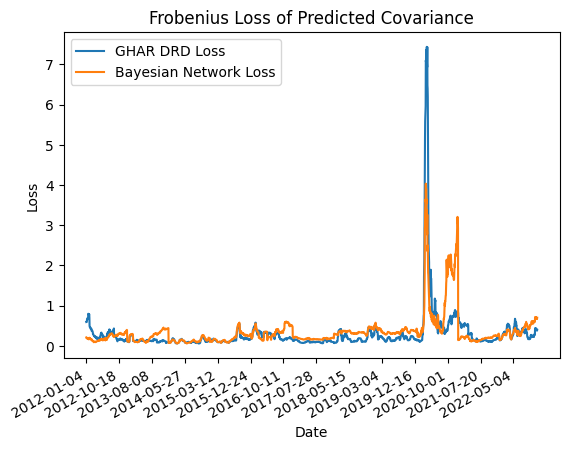

In [63]:
def plot_baseline_vs_ugm_loss(baseline_loss, ugm_loss):
    losses = np.array(list(zip(baseline_loss, ugm_loss))[1:])
    baseline_vals = losses[:, 0, 1].astype(np.float)
    ugm_vals = losses[:, 1, 1].astype(np.float)
    dates = losses[:, 1, 0]
    
    cutoff = 2000
#     baseline_vals = baseline_vals[:cutoff]
#     ugm_vals = ugm_vals[:cutoff]
#     dates = dates[:cutoff]
    
    plt.clf()
    plt.plot(dates, baseline_vals, label="GHAR DRD Loss")
    plt.plot(dates, ugm_vals, label="Bayesian Network Loss")
    plt.xlabel("Date")
    plt.ylabel("Loss")
    plt.gcf().autofmt_xdate()
    plt.xticks(dates[0::200])
    plt.title("Frobenius Loss of Predicted Covariance")
    plt.legend()
    plt.savefig("figs/frob_loss_all.png")
#     plt.savefig("figs/frob_loss_trunc.png")
    plt.show()
plot_baseline_vs_ugm_loss(baseline_loss, ugm_loss)

In [64]:
with open(f"predictions/all_predicted_H_t.pkl", "rb") as f:
    all_predicted_H_t = pickle.load(f)
    

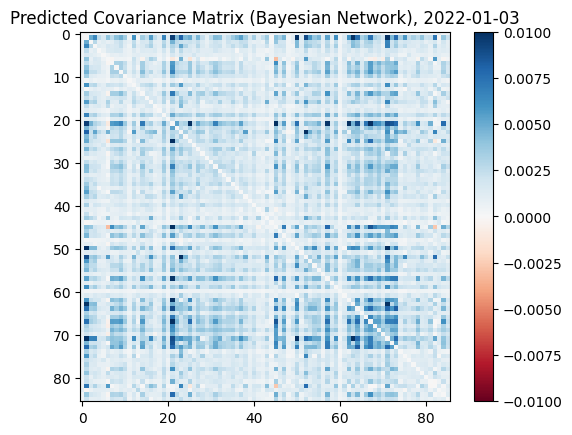

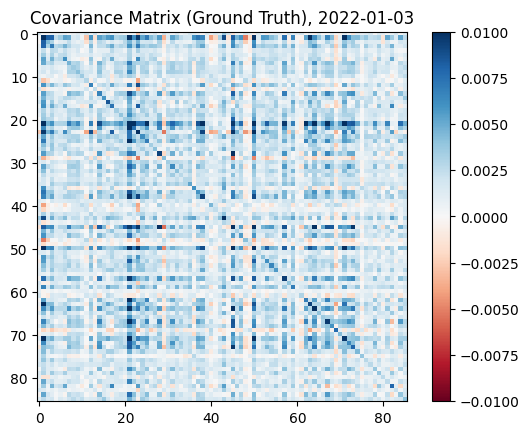

In [85]:
def investigate_H_t(tday):
    predicted_H_t = all_predicted_H_t[tday]
    Ht, _, _, _ = engine.get_HAR_DRD(tday)

    plt.title(f"Predicted Covariance Matrix (Bayesian Network), {tday}")
#     plt.imshow(predicted_H_t, vmin=-0.02, vmax=0.02)
    plt.imshow(predicted_H_t, vmin=-0.01, vmax=0.01, cmap='RdBu')
#     plt.imshow(predicted_H_t)
    plt.colorbar()
    plt.savefig("covariance_mat_predicted.png")
    plt.show()
    
    plt.title(f"Covariance Matrix (Ground Truth), {tday}")
#     plt.imshow(H_t, vmin=-0.02, vmax = 0.02)
    plt.imshow(H_t, vmin=-0.01, vmax = 0.01, cmap='RdBu')
#     plt.imshow(H_t)
    plt.colorbar()
    plt.savefig("covariance_mat_ground_truth.png")
    plt.show()
    
investigate_H_t('2022-01-03')

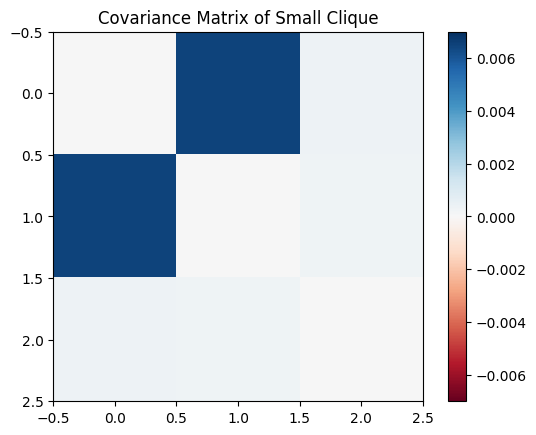

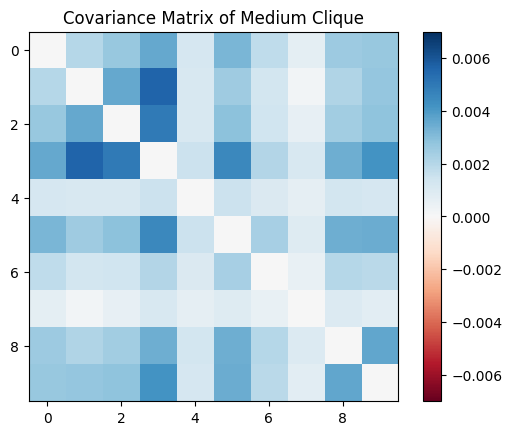

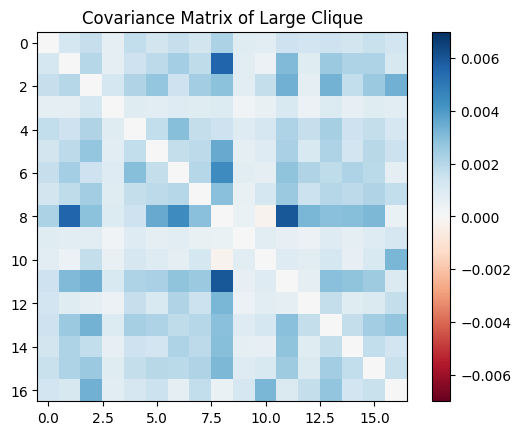

In [116]:
def visualize_clique(clique, H_t, name):
    clique_idx = []
    for ticker in clique:
        clique_idx.append(ticker_to_index[ticker])
    H_t_clique = H_t[clique_idx]
    H_t_clique = H_t_clique.T[clique_idx]
    
    plt.title(f"Covariance Matrix of {name} Clique")
#     plt.xticks(range(len(clique)), clique)
    plt.imshow(H_t_clique, vmin=-0.007, vmax = 0.007, cmap='RdBu')
    plt.colorbar()
    plt.savefig(f"covariance_clique_{name}.png")
    plt.show()
        

cliques = [
    (['AVB', 'NFLX', 'CTSH'], "Small"),
    (['TTWO', 'CMG', 'SYY', 'CL', 'CRL', 'TER', 'MKC', 'BIO', 'GPC', 'WST'], "Medium"),
    (['GIS', 'BWA', 'WST', 'ETN', 'PKG', 'MU', 'CAT', 'ROK', 'HON', 'IEX', 'AMD', 'QCOM', 'ITW', 'INTC', 'LIN', 'ANSS', 'MHK'], "Large")
]

for clique, name in cliques:
    visualize_clique(clique, all_predicted_H_t[tday], name)